# PWBI Admin API Data Pull

In [1]:
# Utilities
import os
from tqdm.notebook import tqdm

# Web Requests
import requests
from urllib.parse import urljoin

# Data Wrangling
import pandas as pd

# Azure Authorization
from azure.identity import InteractiveBrowserCredential

# Datetime utilities
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Logging
import logging

In [2]:
# Notbook Configurations
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Configure logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
logger = logging.getLogger(__name__)

## Key Classes

In [3]:
class PowerBIAPI:
    def __init__(self):
        self.base_url = 'https://api.powerbi.com/v1.0/myorg/'
        self.header = None
        self.update_key_globals()

    def update_key_globals(self, show_display=False):
        credential = InteractiveBrowserCredential()
        credential.authenticate()
        api = 'https://analysis.windows.net/powerbi/api/.default'
        access_token = credential.get_token(api).token
        self.header = {'Authorization': f'Bearer {access_token}'}
        if show_display:
            print(f"Updated Access Token \n{access_token}")

    def response_gate(self, url, params, retry=False):
        response = requests.get(url, params=params, headers=self.header)
        if response.status_code == 200:
            return response
        elif response.status_code == 403 and not retry:
            self.update_key_globals()
            return self.response_gate(url, params, retry=True)
        else:
            raise ValueError(f"Response Status: {response.status_code} with response content {response.json()}")

    def make_api_call(self, url, params):
        return self.response_gate(url, params)
    
    def single_api_call_to_df(self, path, params, data_key=None, record_path=None, meta=None, meta_prefix=None):
        url = urljoin(self.base_url, path)
        try:
            response = self.make_api_call(url, params)
            if response is not None:
                if data_key:
                    data = response.json().get(data_key, [])
                else:
                    data = response.json()
                if record_path:
                    df = pd.json_normalize(data, record_path=record_path, meta=meta, errors='ignore', meta_prefix=meta_prefix)
                else:
                    df = pd.json_normalize(data)
                return df
            else:
                return pd.DataFrame()
        except ValueError as e:
            logger.error(e)
            return pd.DataFrame()

In [4]:
# Initializing class
power_bi_caller = PowerBIAPI()

## Activity API

In [5]:
def activity_json_to_df(response, record_path='activityEventEntities'):
    response_json = response.json()
    df = pd.json_normalize(response_json, record_path=record_path)
    continuation_uri = response_json['continuationUri']
    last_result_set = response_json['lastResultSet']
    return last_result_set, continuation_uri, df
    

def get_view_report_activities(start_date='2023-11-18',end_date='2023-12-17'):

    # Convert to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    delta = timedelta(hours=23, minutes=59, seconds=59, milliseconds=999)

    # Generate dates
    start_dates = []
    end_dates = []
    current = start
    while current <= end:
        start_dates.append(current.strftime("%Y-%m-%dT%H:%M:%S.000Z"))
        end_dates.append((current + delta).strftime("%Y-%m-%dT%H:%M:%S.000Z"))
        current += timedelta(days=1)
        

    # Calling the API
    base_url = 'https://api.powerbi.com/v1.0/myorg/'
    path = 'admin/activityevents'
    url = urljoin(base_url, path)
    
    # Initialize the final activity dataframe
    view_activity_df = []
    
    for start, end in tqdm(zip(start_dates, end_dates), total=len(start_dates)):

        # Initializing Parameters for the API Call
        params = {
            'startDateTime': f"'{start}'",
            'endDateTime': f"'{end}'",
            '$filter': "Activity eq 'viewreport'"
        }
        
        # Calling the Final API URL
        response = power_bi_caller.make_api_call(url, params)

        if response.status_code == 200:
            last_result_set, continuation_uri, first_df = activity_json_to_df(response)
            date_lvl_data = [first_df]
            
            while not last_result_set:
                response = power_bi_caller.make_api_call(continuation_uri, {})
                if response.status_code == 200:
                    last_result_set, continuation_uri, continuation_df = activity_json_to_df(response)
                    date_lvl_data.append(continuation_df)
                else:
                    print(f"Error: {response.status_code} at {response.url} with \n{response.json()}")
                    break

            view_activity_df.extend(date_lvl_data)
        else:
            print(f"Error: {response.status_code} at {response.url} with \n{response.json()}")
            break
    
    return pd.concat(view_activity_df, axis=0) if view_activity_df else pd.DataFrame()

In [6]:
# Calling the API Function
start_date='2024-04-09'
end_date='2024-05-09'

if os.path.isfile(f"data/report_views/reportViewActivity{start_date}_{end_date}.csv"):
    df_view_activity = pd.read_csv(f"data/report_views/reportViewActivity{start_date}_{end_date}.csv")
else:
    df_view_activity = get_view_report_activities(start_date, end_date)
    df_view_activity.to_csv(f"data/report_views/reportViewActivity{start_date}_{end_date}.csv")

In [7]:
# Removing BI team members
bi_team_members = [
    'lakshmi.n@gagroup.net', 'pooja.s@gagroup.net', 'Prajwal.G@gagroup.net', 
    'Sachin.bm@gagroup.net', 'elizabeth@gagroup.net', 'aravindhakshan.r@gagroup.net'
]

df_view_activity = df_view_activity[~(df_view_activity.UserId.isin(bi_team_members))].copy().reset_index()

In [8]:
# Ensure CreationTime is a datetime object
df_view_activity['CreationTime'] = pd.to_datetime(df_view_activity['CreationTime'])

# Convert the datetime to timezone-aware (assuming original is UTC)
df_view_activity['CreationTime'] = df_view_activity['CreationTime'].dt.tz_localize('UTC')

# Now convert to 'Asia/Dubai' timezone
df_view_activity['CreationTimeLocal'] = df_view_activity['CreationTime'].dt.tz_convert('Asia/Dubai')

# Extracting date and time
df_view_activity['ActivityDate'] = df_view_activity['CreationTimeLocal'].dt.date
df_view_activity['ActivityTime'] = df_view_activity['CreationTimeLocal'].dt.time
df_view_activity['Activityhour'] = df_view_activity['CreationTimeLocal'].dt.hour

## Workspace Expanded Reports

In [9]:
path = 'admin/groups'
params = {
    '$expand': 'reports',
    '$top': 1000
}
df_groups_e = power_bi_caller.single_api_call_to_df(
    path=path, 
    params=params, 
    data_key='value', 
    record_path='reports',
    meta=[
        'id','isOnDedicatedCapacity', 'capacityMigrationStatus',
        'type','state','name','capacityId','defaultDatasetStorageFormat'
    ],
    meta_prefix='workspace_'
)

In [10]:
df_groups_e = df_groups_e[
    [
        'workspace_id','workspace_name','workspace_type','workspace_state',
        'workspace_isOnDedicatedCapacity','workspace_capacityMigrationStatus',
        'workspace_capacityId','workspace_defaultDatasetStorageFormat',   
        'id', 'name', 'datasetId', 'appId', 'createdDateTime', 'modifiedDateTime'
    ]
].copy()
df_groups_e = df_groups_e[df_groups_e['workspace_type'] == 'Workspace'].copy()
df_groups_e.rename(
    {
        'id': 'report_id',
        'name': 'report_name',
        'createdDateTime': 'reportCreatedDatetime',
        'modifiedDateTime': 'reportModifiedDatetime'
    },
    inplace=True,
    axis=1
)

print(f"Shape of groups = {df_groups_e.shape}")
df_groups_e.to_csv('data/workspaces/groups_e.csv')

Shape of groups = (952, 14)


In [11]:
# Active Groups only
df_active_groups = df_groups_e[df_groups_e['workspace_state']=='Active'].copy()
print(f"Shape of active groups = {df_active_groups.shape}")
df_active_groups.to_csv('data/workspaces/active_groups_e.csv')

Shape of active groups = (952, 14)


In [12]:
# Enriched with app data
df_active_groups_wide = pd.merge(
    left = df_active_groups[df_active_groups['appId'].isna()==True],
    right = df_active_groups[df_active_groups['appId'].isna()==False][
        [
            'workspace_id','datasetId','report_id','report_name','appId','reportCreatedDatetime','reportModifiedDatetime'
        ]
    ],
    how = 'left',
    left_on = ['workspace_id','datasetId'],
    right_on = ['workspace_id','datasetId']
)

df_active_groups_wide = df_active_groups_wide[
    [
        'workspace_id', 'workspace_name', 'workspace_type', 'workspace_state',
        'workspace_isOnDedicatedCapacity', 'report_id_x', 'report_name_x', 
        'datasetId','reportCreatedDatetime_x', 'reportModifiedDatetime_x', 
        'report_id_y', 'report_name_y', 'appId_y', 'reportCreatedDatetime_y',
        'reportModifiedDatetime_y'
    ]
].copy()

df_active_groups_wide.rename(
    {
        'report_id_x': 'report_id',
        'report_name_x': 'report_name',
        'reportCreatedDatetime_x': 'reportCreatedDatetime',
        'reportModifiedDatetime_x': 'reportModifiedDatetime',
        'report_id_y': 'app_report_id',
        'report_name_y': 'app_report_name',
        'reportCreatedDatetime_y': 'app_reportCreatedDatetime',
        'reportModifiedDatetime_y': 'app_reportModifiedDatetime',
        'appId_y': 'appId'
    },
    axis=1,
    inplace=True

)

# Fill NaNs to carry out str operations
df_active_groups_wide['app_report_name'].fillna('Not Applicable', inplace=True)

# Itentify duplicate matches
df_active_groups_wide['duplicate_match_flag'] = df_active_groups_wide.apply(lambda x: 1 if ((x['report_name'].strip() in x['app_report_name'].strip()) or (x['app_report_name'] == 'Not Applicable')) else 0, axis=1)

print(df_active_groups_wide.shape)
df_active_groups_wide.to_csv('data/workspaces/active_groups_e_wide.csv')

(702, 16)


In [13]:
# Report Level Views
df_report_views = df_view_activity.groupby('ReportId').agg(
    {
        'UserKey': [('reportUserCount', lambda x: x.nunique()), ('viewerCount', 'count')],
        'CreationTime': [('latestAccess','min')]
    }

).reset_index()

# Flatten the MultiIndex in columns
df_report_views.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in df_report_views.columns.values]

df_report_views.rename(
    {
        'ReportId_': 'report_id',
        'UserKey_reportUserCount' : 'reportUserCount',
        'UserKey_viewerCount' : 'reportViewerCount',
        'CreationTime_latestAccess': 'reportLatestAccess'
    },
    axis=1,
    inplace=True

)

df_report_views['report_id'] = df_report_views['report_id'].str.upper()

In [14]:
# merging the view table
df_active_groups_wide = pd.merge(left=df_active_groups_wide, right=df_report_views, how='left', left_on='report_id', right_on='report_id')

In [15]:
df_active_groups_wide.head(10)

,workspace_id,workspace_name,workspace_type,workspace_state,workspace_isOnDedicatedCapacity,report_id,report_name,datasetId,reportCreatedDatetime,reportModifiedDatetime,app_report_id,app_report_name,appId,app_reportCreatedDatetime,app_reportModifiedDatetime,duplicate_match_flag,reportUserCount,reportViewerCount,reportLatestAccess
0,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,9CC53724-87A3-4FD0-937E-8A82F6096091,Dashboard Usage Metrics Report,6a25f78e-cb37-4c40-a631-100cefbc9b94,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,1,NaN,NaN,NaT
1,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,A70207EA-4C6B-4EF5-8D7B-7A2A1EC12DA8,Report Usage Metrics Report,916afafc-4cb4-497c-961a-2b9259fd48f0,NaN,NaN,NaN,Not Applicable,NaN,NaN,NaN,1,NaN,NaN,NaT
2,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,B220AE4D-AB3D-4E68-9C60-26449EA95646,Usage Metrics Report,4484265f-2264-4e92-8562-7ac0a80a9c1b,2022-09-20T12:14:43.173Z,2022-09-20T12:14:43.173Z,NaN,Not Applicable,NaN,NaN,NaN,1,NaN,NaN,NaT
3,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,0B5FBBFC-8F31-4132-9A4E-39E3E5900DD8,Inventory Adjustment Reports_V1,ae946410-2a59-414c-8798-723a59d18ec2,2022-12-08T19:19:13.443Z,2023-12-27T08:27:00.137Z,2225E7AC-6CA5-49AF-A047-4D0B25C81CFA,[App] Inventory Adjustment Reports_V1,4328a84b-79a4-4977-a9d7-70fdd5bb91c7,2023-02-15T06:21:41.053Z,2024-04-08T06:11:48.553Z,1,3.0,3.0,2024-04-20 12:22:46+00:00
4,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,5E793167-E51B-421D-98C5-7A63D005C349,Customer Analysis_V1,ec1e4cf2-dde9-49c6-ba79-f2c0fd3a09bf,2022-12-08T19:21:37.47Z,2023-12-27T08:24:51.75Z,048D6B53-1395-4536-9DD0-6DD19FCA309F,[App] Customer Analysis_V1,4328a84b-79a4-4977-a9d7-70fdd5bb91c7,2023-02-15T06:21:41.053Z,2024-04-08T06:11:48.553Z,1,8.0,17.0,2024-04-12 19:12:15+00:00
5,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,3EF40570-CF10-4C55-9BB5-106B62CAC4A1,Inventory Reports_V1,312d14a3-b783-4b32-8abe-def323f5d54f,2022-12-08T19:22:50.087Z,2023-12-27T09:02:44.79Z,5AF0E7C9-C7CB-4BCE-A326-C8F8A1AAAA46,[App] Inventory Reports_V1,4328a84b-79a4-4977-a9d7-70fdd5bb91c7,2023-02-15T06:21:41.053Z,2024-04-08T06:11:48.553Z,1,5.0,5.0,2024-04-15 08:06:18+00:00
6,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,AE4A035B-4EDD-405E-A68A-DA43C984E1CC,Purchase Reports_V1,e9bbb852-d115-4d65-a302-c43052989d59,2022-12-08T19:25:54.13Z,2023-12-27T09:03:52.133Z,6B8DA91C-69AB-4978-BC44-56A7A8708E64,[App] Purchase Reports_V1,4328a84b-79a4-4977-a9d7-70fdd5bb91c7,2023-02-04T08:03:43.833Z,2024-04-08T06:11:48.553Z,1,27.0,100.0,2024-04-12 13:52:23+00:00
7,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,C47569E1-20A8-45CB-9B57-73F154136EF6,Sales Reports from Ledgers_v1,45b1f28d-ebf5-4a74-8149-36fa4fcb65ed,2022-12-08T19:30:46.43Z,2023-12-27T09:16:45.53Z,8E435139-7B2D-4259-B0A4-59D0485AAF60,[App] Sales Reports from Ledgers_v1,4328a84b-79a4-4977-a9d7-70fdd5bb91c7,2023-02-15T06:21:41.053Z,2024-04-08T06:11:48.553Z,1,5.0,6.0,2024-04-22 04:32:01+00:00
8,3be941d8-fb28-4603-979b-3795a778c77f,Grandiose,Workspace,Active,True,C0ACE0E6-AC68-4482-897E-7BB21824956A,Sales Reports from POS Trans_V3,8770b7c4-9462-42ff-8f8f-1edd5a076ff1,2023-01-18T13:02:15.73Z,2023-12-27T09:25:35.55Z,2D7A5926-421E-483C-A42B-0DD44BF5786B,[App] Sales Reports from POS Trans_V3,4328a84b-79a4-4977-a9d7-70fdd5bb91c7,2023-02-15T06:21:41.053Z,2024-04-08T06:11:48.553Z,1,11.0,21.0,2024-04-13 07:37:13+00:00
9,8dd061ff-43d1-4e7e-893d-4c8b9e4e5bb7,Olive Country Reports,Workspace,Active,False,A05ADED5-9A7E-4218-91B3-FC9121D3D656,Brand Sales Report,051c2701-3d54-418f-b186-8115b716848c,2021-01-20T04:57:09.04Z,2022-07-13T11:08:10.877Z,NaN,Not Applicable,NaN,NaN,NaN,1,NaN,NaN,NaT


## Datasets

In [43]:
# Get Datasets
path = 'admin/datasets'
params = {}

csv_path = f"data/datasets/{path.split('/')[-1]}.csv"

if 'df_datasets' not in globals():
    try:
        df_datasets = pd.read_csv(csv_path)
    except FileNotFoundError:
        df_datasets = power_bi_caller.single_api_call_to_df(
            path=path, 
            params=params, 
            data_key='value'  # Assuming the key for datasets in the response is 'value'
        )
        df_datasets.to_csv(csv_path)

print(f"Shape of the extracted data is {df_datasets.shape}")

Shape of the extracted data is (608, 20)


In [44]:
df_datasets = df_datasets[
    [
        'id', 'name', 'configuredBy', 'isRefreshable', 'createdDate','contentProviderType','workspaceId'
    ]
].rename(
    {
        'id': 'datasetId',
        'name': 'datasetName',
    },
    axis = 1
).copy()

In [45]:
print(f"Shape of the df_datasets = {df_datasets.shape}")
df_datasets.head(2)

Shape of the df_datasets = (608, 7)


,datasetId,datasetName,configuredBy,isRefreshable,createdDate,contentProviderType,workspaceId
0,1f6d9c95-8581-405b-ad68-e94f95b0fc77,POS Transaction Reports,b.joseph@gagroup.net,False,2017-07-31T08:54:26.797Z,Unknown,24fd5829-f54e-4eba-8a3a-43f84a6bc60f
1,6a25f78e-cb37-4c40-a631-100cefbc9b94,Dashboard Usage Metrics Model,b.joseph@gagroup.net,False,2017-07-31T09:01:14.087Z,UsageMetricsUserDashboard,3be941d8-fb28-4603-979b-3795a778c77f


### Refresh Schedule
Getting the refresh schedule of the datasets that are refreshable

In [24]:
# Initialize DataFrame 
df_refresh_schedule = pd.DataFrame()
df_refresh_history = pd.DataFrame()

# Progress bar setup
pbar = tqdm(total=df_datasets.shape[0], desc='Datasets', position=0)

for dataset in df_datasets[df_datasets['isRefreshable'] == True]['datasetId']:
    path_1 = f'datasets/{dataset}/refreshSchedule'
    path_2 = f'datasets/{dataset}/refreshes'
    inner_df_1 = power_bi_caller.single_api_call_to_df(path=path_1, params={})
    inner_df_2 = power_bi_caller.single_api_call_to_df(path=path_2, params={}, data_key='value')
    if not inner_df_1.empty:
        inner_df_1['datasetId'] = dataset
        df_refresh_schedule = pd.concat([df_refresh_schedule, inner_df_1], axis=0)
    if not inner_df_2.empty:
        inner_df_2['datasetId'] = dataset
        df_refresh_history = pd.concat([df_refresh_history, inner_df_2], axis=0)
    pbar.update(1)

pbar.close()

# Post-processing
# df_refresh_schedule
df_refresh_schedule.days = df_refresh_schedule.days.apply(lambda x: ','.join(x) if isinstance(x, list) else x)
df_refresh_schedule.times = df_refresh_schedule.times.apply(lambda x: ','.join(x) if isinstance(x, list) else x)
df_refresh_schedule.drop_duplicates(inplace=True)

# df_refresh_history
df_refresh_history['startTime'] = pd.to_datetime(df_refresh_history['startTime']).dt.tz_convert('Asia/Dubai')
df_refresh_history['endTime'] = pd.to_datetime(df_refresh_history['endTime']).dt.tz_convert('Asia/Dubai')
df_refresh_history['refreshDuration'] = df_refresh_history['endTime'] - df_refresh_history['startTime']

# Creating a persistent copy
df_refresh_schedule.to_csv('data/refresh_schedule/refresh_schedule.csv')
df_refresh_history.to_csv('data/refresh_history/refresh_history.csv')

# Optionally, handle or log errors
# for error in error_list:
#     print(error)
#     # Or log the error

2024-05-09 14:06:52,945 - ERROR - Response Status: 404 with response content {'error': {'code': 'ItemNotFound', 'message': 'Dataset 4f0914a8-ae3a-454d-ada9-89ce00d75076 is not found! please verify datasetId is correct and user have sufficient permissions.'}}
2024-05-09 14:06:53,488 - ERROR - Response Status: 404 with response content {'error': {'code': 'ItemNotFound', 'message': "Couldn't find dataset id "}}
2024-05-09 14:06:54,068 - ERROR - Response Status: 404 with response content {'error': {'code': 'ItemNotFound', 'message': 'Dataset 5a0677f1-3338-4f23-b0d0-342573c8814e is not found! please verify datasetId is correct and user have sufficient permissions.'}}
2024-05-09 14:06:54,594 - ERROR - Response Status: 404 with response content {'error': {'code': 'ItemNotFound', 'message': "Couldn't find dataset id "}}
2024-05-09 14:06:55,096 - ERROR - Response Status: 404 with response content {'error': {'code': 'ItemNotFound', 'message': 'Dataset dbe3596a-f72d-4714-af1d-be4561d9f620 is not 

In [46]:
df_datasets = pd.merge(left=df_datasets, right=df_refresh_schedule[['datasetId', 'times', 'days','enabled','localTimeZoneId']], how='left', left_on='datasetId', right_on='datasetId')
df_datasets = df_datasets[
    [
        'datasetId', 'datasetName', 'configuredBy', 'isRefreshable', 'createdDate',
        'contentProviderType','workspaceId','times', 'days', 'enabled', 'localTimeZoneId'
    ]
].rename(
    {
        'times': 'refreshTimes',
        'days': 'refreshDays',
        'enabled': 'refreshEnabled',
    }, 
    axis='columns'
).copy()
print(f"Shape of the updated reports dataframe is {df_datasets.shape}")

Shape of the updated reports dataframe is (608, 11)


In [47]:
df_datasets.shape

(608, 11)

### Refresh History
Getting the refresh history of the datasets

In [38]:
df_dataset_refresh_stats = df_refresh_history.groupby('datasetId').agg({
    'startTime': 'max',
    'refreshDuration': lambda x: x.dt.seconds.mean()
}).reset_index().rename(
    {
        'startTime': 'latestRefreshDate',
        'refreshDuration': 'avgRefreshDuration'
    }, axis=1)
df_dataset_refresh_stats.columns

Index(['datasetId', 'latestRefreshDate', 'avgRefreshDuration'], dtype='object')

In [48]:
df_datasets = pd.merge(left=df_datasets, right=df_dataset_refresh_stats, how='left', left_on='datasetId', right_on='datasetId')
df_datasets = df_datasets[
    [
        'datasetId', 'datasetName', 'configuredBy', 'isRefreshable', 'createdDate',
        'contentProviderType','workspaceId','refreshTimes', 'refreshDays', 'refreshEnabled', 
        'localTimeZoneId', 'latestRefreshDate', 'avgRefreshDuration'
    ]
].copy() 
df_datasets['avgRefreshDuration'] = df_datasets['avgRefreshDuration']/60
print(f"Shape of the updated reports dataframe is {df_datasets.shape}")

Shape of the updated reports dataframe is (608, 13)


In [49]:
## Creating fin
final_master = pd.merge(left=df_active_groups_wide, right=df_datasets, how='left', left_on='datasetId', right_on='datasetId')

In [50]:
final_master = final_master[
    [
        'workspace_id', 'workspace_name', 'workspace_type', 'workspace_state','workspace_isOnDedicatedCapacity', 
        'report_id', 'report_name','reportCreatedDatetime', 'reportModifiedDatetime',
        'reportUserCount', 'reportViewerCount','reportLatestAccess',
        'app_report_id', 'app_report_name', 'appId','app_reportCreatedDatetime', 'app_reportModifiedDatetime',
        'duplicate_match_flag',
        'datasetId','datasetName', 'configuredBy', 'isRefreshable', 'createdDate', 'contentProviderType', 'refreshTimes',
        'refreshDays', 'refreshEnabled', 'localTimeZoneId', 'latestRefreshDate','avgRefreshDuration', 
    ]
].copy()

In [51]:
final_master.to_csv('data/final_master_20240509.csv')

## Usage

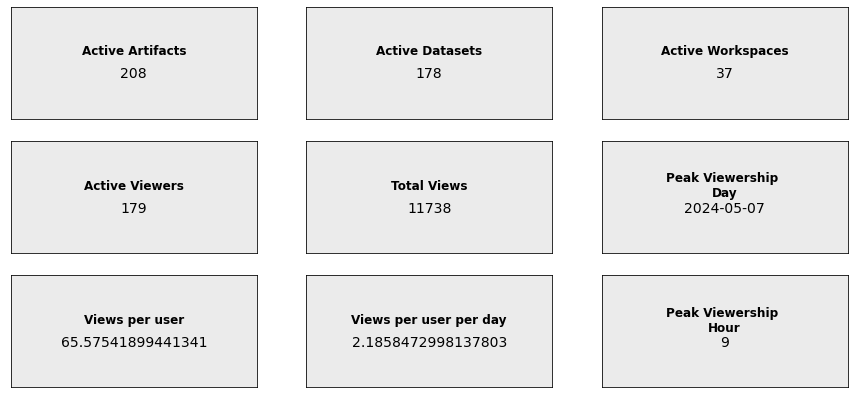

In [52]:
# Total Number of active workspaces
active_workspaces = df_view_activity['WorkspaceId'].nunique()

# Total Number of active artifacts
active_artifacts = df_view_activity['ArtifactId'].nunique()

# Total Number of active Datasets
active_datasets = df_view_activity['DatasetId'].nunique()

# Total Unique Users in the last 30 days
active_users = df_view_activity['UserKey'].nunique()

# Total Number of Views in the last 30 Days
total_views = df_view_activity['ActivityId'].nunique()

# Average Views per User
views_per_user = df_view_activity['ActivityId'].nunique()/df_view_activity['UserKey'].nunique()

# Average Views per User per day
views_per_user_per_day = df_view_activity['ActivityId'].nunique()/df_view_activity['UserKey'].nunique()/30

# Peak Viewership Day
peak_viewership_day = df_view_activity.groupby('ActivityDate')['UserKey'].nunique().idxmax()

# Peak Viewship Hour
peak_viewership_hour = df_view_activity.groupby('Activityhour')['UserKey'].nunique().idxmax()

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,7))


def create_kpi_box(ax, title, value, color):
    # Use the entire axes to draw the rectangle
    ax.add_patch(Rectangle((0, 0), 1, 1, color=color, alpha=0.3, transform=ax.transAxes))

    # Add text
    ax.text(0.5, 0.6, title, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.4, value, ha='center', va='center', fontsize=14, transform=ax.transAxes)

    # Remove the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Creating KPI boxes
create_kpi_box(ax[0,0], 'Active Artifacts', f'{active_artifacts}', 'silver')
create_kpi_box(ax[0,1], 'Active Datasets', f'{active_datasets}', 'silver')
create_kpi_box(ax[0,2], 'Active Workspaces', f'{active_workspaces}', 'silver')
create_kpi_box(ax[1,0], 'Active Viewers', f'{active_users}', 'silver')
create_kpi_box(ax[1,1], 'Total Views', f'{total_views}', 'silver')
create_kpi_box(ax[1,2], 'Peak Viewership \nDay', f'{peak_viewership_day:%Y-%m-%d}', 'silver')
create_kpi_box(ax[2,0], 'Views per user', f'{views_per_user}', 'silver')
create_kpi_box(ax[2,2], 'Peak Viewership \nHour', f'{peak_viewership_hour}', 'silver')
create_kpi_box(ax[2,1], 'Views per user per day', f'{views_per_user_per_day}', 'silver')

plt.show()

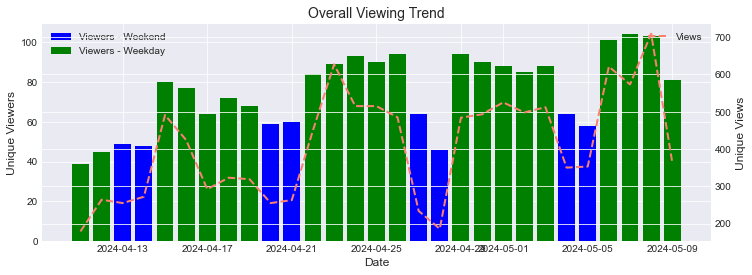

In [54]:
# Viewer Trend
view_trend = df_view_activity.groupby('ActivityDate').agg({
    'UserKey': lambda x:x.nunique(),
    'ActivityId': lambda x:x.nunique()
}).reset_index().set_index('ActivityDate')

# Converting index to datetime
view_trend.index = pd.to_datetime(view_trend.index)

# Identify weekends
weekends = view_trend.index.weekday >= 5

plt.style.use('seaborn-darkgrid')  # Example of setting a style

fig, ax = plt.subplots(figsize=(12, 4))

# Bar chart
# Coloring weekends differently
ax.bar(view_trend.index[weekends], view_trend.loc[weekends, 'UserKey'], label='Viewers - Weekend', color='blue')
ax.bar(view_trend.index[~weekends], view_trend.loc[~weekends, 'UserKey'], label='Viewers - Weekday', color='green')


# Line plot with a secondary axis
ax2 = ax.twinx()
ax2.plot(view_trend.index, view_trend['ActivityId'], label='Views', color='salmon', linestyle='--', linewidth=2)

# Enhancements
ax.set_title("Overall Viewing Trend", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Unique Viewers", fontsize=12)
ax2.set_ylabel("Unique Views", fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date
plt.xticks(rotation=45)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.grid(True)


In [55]:
# Average viewership
view_trend['weekends'] = view_trend.index.weekday >= 5

print(f"Average Views: \n{view_trend.groupby('weekends')['ActivityId'].mean()}")
print(f"Average Viewers: \n{view_trend.groupby('weekends')['UserKey'].mean()}")

Average Views: 
weekends
False    460.142857
True     271.000000
Name: ActivityId, dtype: float64
Average Viewers: 
weekends
False    82.333333
True     56.000000
Name: UserKey, dtype: float64


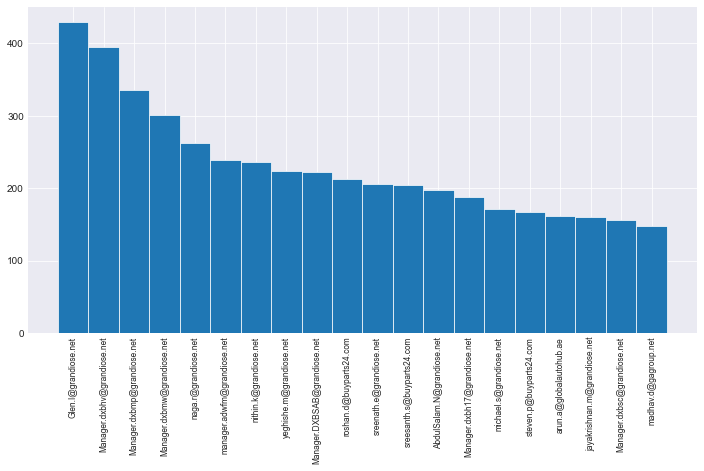

In [56]:
import re
def extract_domain(email):
    """
    Function to extract the domain from an email address.

    Parameters:
    email (str): The email address from which to extract the domain.

    Returns:
    str: The extracted domain.
    """
    match = re.search(r'(?<=@)[^>]+', email)
    if match:
        return match.group()
    return None  # Return None or an appropriate value if the domain isn't found


#Top 20 Users

viewer_trend = df_view_activity.groupby(['UserKey','UserId']).agg({
    'ActivityId': lambda x:x.nunique()
}).reset_index().sort_values('ActivityId', ascending=False)

viewer_trend['domain'] = viewer_trend['UserId'].apply(extract_domain)

# plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(viewer_trend['UserId'].head(20), viewer_trend['ActivityId'].head(20), width=1, edgecolor="white", linewidth=0.7)

plt.xticks(rotation=90) 
plt.tick_params(axis='x', which='major', labelsize='small')
plt.show()

In [57]:
domain_lvl = viewer_trend.groupby('domain').agg(
    {
        'ActivityId': 'sum',
        'UserKey': lambda x: x.nunique()
    }

).reset_index()
domain_lvl['views_user'] = domain_lvl['ActivityId']/domain_lvl['UserKey']
domain_lvl

,domain,ActivityId,UserKey,views_user
0,aboudparts.com,57,2,28.500000
1,buygro.com,270,6,45.000000
2,buyparts24.com,1902,26,73.153846
3,flourcountry.com,20,1,20.000000
4,gaelanmedical.com,1,1,1.000000
5,gagroup.net,587,22,26.681818
6,gallega.com,17,7,2.428571
7,globalautohub.ae,161,1,161.000000
8,grandiose.net,8548,105,81.409524
9,grandiosecatering.com,109,4,27.250000


In [58]:
print(f"Total Users: {viewer_trend['UserKey'].nunique()}")
print(viewer_trend.groupby('domain')['UserKey'].nunique(),"\n")


Total Users: 179
domain
aboudparts.com             2
buygro.com                 6
buyparts24.com            26
flourcountry.com           1
gaelanmedical.com          1
gagroup.net               22
gallega.com                7
globalautohub.ae           1
grandiose.net            105
grandiosecatering.com      4
olivecountry.com           4
Name: UserKey, dtype: int64 



In [48]:
viewer_trend.groupby('domain').head(5).sort_values('domain')[['UserId', 'ActivityId', 'domain']].to_csv('user_trend.csv')

In [61]:
# Top 3 overall
final_master.sort_values('reportUserCount', ascending=False)[['workspace_name', 'report_name', 'reportUserCount', 'reportViewerCount']]

# Top 3 across the workspaces
# df_active_groups2.sort_values('reportUserCount', ascending=False).groupby('workspace_name').head(3)[['workspace_name', 'report_name', 'reportUserCount', 'reportViewerCount']].sort_values('workspace_name')

,workspace_name,report_name,reportUserCount,reportViewerCount
40,Grandiose Report,KPI Benchmark V3,69.0,1462.0
559,Grandiose Operations App,Stock Ageing Report,54.0,455.0
613,Grandiose Sales App,Sales Report New Category,52.0,734.0
42,Grandiose Report,Daily Sales Report For All Stores V3,47.0,554.0
612,Grandiose Sales App,KPI Report,42.0,519.0
41,Grandiose Report,Stock Value Report Trend V2,41.0,270.0
595,Grandiose Sales App,Item Sales Comparison,40.0,424.0
59,Grandiose Report,Item Sales Report V2,39.0,290.0
45,Grandiose Report,Wastage Details Report V2,39.0,190.0
43,Grandiose Report,Grandiose Sales Analysis V3,38.0,179.0


In [ ]:
df_active_groups2.to_csv('data/df_active_groups.csv')

## Appendix

In [ ]:
# old logic for updating access_token globals
credential = InteractiveBrowserCredential()
credential.authenticate()

api = 'https://analysis.windows.net/powerbi/api/.default'
access_token = credential.get_token(api)
access_token = access_token.token

access_token

In [ ]:
base_url = 'https://api.powerbi.com/v1.0/myorg/'
header = {'Authorization': f'Bearer {access_token}'}

In [ ]:
# Old logic for activities
path = 'admin/activityevents'
url = urljoin(base_url, path)

final_df = pd.DataFrame()

for each in tqdm(zip(start_dates, end_dates), total=len(start_dates)):

    initial_df = pd.DataFrame()
    intermediate_df = pd.DataFrame()
    pen_df = pd.DataFrame()

    params = {
        'startDateTime': f"'{each[0]}'",
        'endDateTime': f"'{each[-1]}'",
        '$filter': "Activity eq 'viewreport'"
    }

    initial_response = requests.get(url, params=params, headers=header)

    if initial_response.status_code == 200:
        initial_df = pd.json_normalize(initial_response.json(), record_path='activityEventEntities')
        continuation_uri = initial_response.json()['continuationUri']
        last_result_set = initial_response.json()['lastResultSet']
        while last_result_set == False:
            intermediate_response = requests.get(continuation_uri, headers=header)
            if intermediate_response.status_code == 200:
                intermediate_df = pd.json_normalize(intermediate_response.json(), record_path='activityEventEntities')
                pen_df = pd.concat([pen_df,intermediate_df ], axis = 0)
                continuation_uri = intermediate_response.json()['continuationUri']
                last_result_set = intermediate_response.json()['lastResultSet']
            else:
                print(intermediate_response.status_code)
                break
        final_df = pd.concat([final_df,initial_df,pen_df], axis=0)
    else:
        print(initial_response.status_code)
        print(initial_response.url)
        print(initial_response.json)
        break 
    